# Wstęp

Na dzisiejszych zajęciach będziemy zajmować się algorytmami drzewiastymi. Poznamy dwa algorytmy z biblioteki scikit-learn: random forest (lasy losowe) oraz extra trees.

Dane, na których będziemy pracować dotyczą tzw. klasyfikacji zdarzeń akustycznych (*acoustic event classification*), czyli różnego rodzaju dźwięków, które można spotkać w mieście: głosy ludzi, zwierząt, odgłosy wydawane przez urządzenia techniczne, samochody itp. Jest to dość trudny problem klasyfikacyjny, ponieważ próbujemy nauczyć model rozpoznawania wielu klas naraz.

Źrodło danych: https://www.kaggle.com/chrisfilo/urbansound8k?fbclid=IwAR2AwTcNOEFFJGq3Me5C2o6lLJ_jMTzo5PUdB2EWStjTaBq1z1CVCCQG0Uc

In [25]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_validate, GroupKFold
import scipy.stats

Tak jak ostatnio, będziemy pracować na plikach z wyekstrahowanymi wcześniej cechami, żeby nie tracić czasu na ich wyliczanie. Będziemy wykorzystywać dwa rodzaje cech: MFCC oraz bardzo podobne do nich GFCC (*gammatone frequency cepstral coefficients*). 

## Wczytanie danych
Wczytujemy 3 pliki:
- **mfcc_feats.npy** - macierz z 13 MFCC
- **labels.npy** - wektor z labelami (przyporządkowaniem do klas)
- **folds.npy** - podział na podzbiory, który ma być wykorzystany podczas walidacji krzyżowej. 

Dotychczas walidację krzyżową robiliśmy dzieląc dane na podzbiory w sposób losowy - czasem podział jest istotny i powinien być przeprowadzony w określony sposób. Jest tak np. wtedy, gdy w bazie znajduje się więcej niż jeden sygnał zawierający dźwięki emitowane przez to samo urządzenie lub tę samą osobę. Wtedy należy zagwarantować, żeby  wszystkie sygnały związane z tym samym obiektem znalazły się w tym samym podzbiorze - gdyby tak nie było, to uzyskalibyśmy sztucznie zawyżone metryki i mielibyśmy złe pojęcie o jakości naszego modelu.

Korzystamy zatem z podziału dokonanego przez autorów bazy danych.

In [26]:
# jeśli zamontujemy dysk Google w notatniku, mamy dostęp do wszystkich plików na nim, po ścieżkach zaczynających się od /content/drive - działa to tak jak montowanie dysków w linuxie
# można dodać podlinkowany zip z danymi jako skrót na swoim dysku - wtedy omijamy etap pobierania plików
# from pathlib import Path
# from google.colab import drive
# drive.mount('/content/drive/')

data_path = ('') # podmień na swoją ścieżkę do danych

In [27]:
X_mfcc = np.load(data_path + 'mfcc_3D.npy')
y_org = np.load(data_path + 'labels.npy')
folds = np.load(data_path + 'folds.npy')

classes = {0: 'airconditioner',
           1: 'carhorn',
           2: 'childrenplaying',
           3: 'dogbark',
           4: 'drilling',
           5: 'engineidling',
           6: 'gunshot',
           7: 'jackhammer',
           8: 'siren',
           9: 'street_music'}

X_mfcc.shape #mamy 7334 sygnałów o długości 341 ramek, z każdego wyekstrahowano 13 MFCC

(7334, 341, 13)

## Redukcja wymiarowości
Gdybyśmy utworzyli z macierzy MFCC wektor, mielibyśmy każdy sygnał opisany 4433 cechami - algorytmy drzewiaste uczyłyby się na takich danych bardzo długo, chcemy więc zmniejszyć liczbę cech.

Tym razem nie będziemy zmniejszać wymiarowości danych używając algorytmów, które poznaliśmy do tej pory. Zamiast tego wyznaczymy parametry statystyczne charakteryzujące każdy kanał (każdy z 13 współczynników cepstralnych) na całej długości sygnału. Będą to bardzo podstawowe parametry:
- wartość średnia, 
- odchylenie standardowe, 
- mediana, 
- I i III kwartyl, 
- rozrzut pomiędzy 10 i 90 percentylem, 
- kurtoza, 
- skośność, 
- wartość minimalna,
- wartość maksymalna. 

Takie cechy są czasem stosowane w przemyśle, np. w analizie mowy, więc warto wiedzieć, że można ich używać i że potrafią dawać dobre rezultaty.

Teraz każdy sygnał będzie opisany tylko 130 cechami, więc można prowadzić proces uczenia, walidacji i predykcji bez dalszej redukcji wymiarowości.

In [28]:
X = np.hstack((np.mean(X_mfcc, axis=1), 
               np.std(X_mfcc, axis=1), 
               np.median(X_mfcc, axis=1), 
               np.percentile(X_mfcc, 25, axis=1), 
               np.percentile(X_mfcc, 75, axis=1), 
               scipy.stats.iqr(X_mfcc, rng=(10, 90), axis=1),
               scipy.stats.kurtosis(X_mfcc, axis=1),
               scipy.stats.skew(X_mfcc, axis=1),
               np.min(X_mfcc, axis=1),
               np.max(X_mfcc, axis=1)
              ))

Wyświetlmy liczebność poszczególnych klas, żeby zobaczyć, czy mają podobną liczebność - jeżeli różnica pomiędzy liczebnością klas będzie bardzo duża, to prawdopodobnie klasyfikator nie będzie w stanie nauczyć się ich poprawnie rozpoznawać bez dodatkowego preprocessingu, np. nad- lub podpróbkowania klas.

In [29]:
from collections import Counter
Counter(y_org)

Counter({np.float64(9.0): 1000,
         np.float64(0.0): 997,
         np.float64(2.0): 976,
         np.float64(5.0): 961,
         np.float64(8.0): 897,
         np.float64(4.0): 805,
         np.float64(7.0): 804,
         np.float64(3.0): 675,
         np.float64(1.0): 203,
         np.float64(6.0): 16})

Jak widać, najmniej liczna jest klasa 6 - należy do niej tylko 16 obiektów, czyli 0,2% wszystkich danych. Usuniemy wszystkie obiekty z tej klasy ze zbioru danych, ponieważ będą tylko utrudniać proces uczenia, a przykładów jest najpewniej za mało, aby klasyfikator nauczył się je rozpoznawać.

**Uwaga:** tutaj nadpisujemy zmienne, trzeba na to uważać, gdybyśmy cofali się do wcześniejszych etapów notebooka. 

In [30]:
# korzystamy z masek do filtrowania danych

#usuwanie klasy 6 ze zbioru danych
y_not_6 = y_org!=6
print('Przed usunięciem klasy 6:', folds.shape)

X = X[y_not_6]
y = y_org[y_not_6]
folds = folds[y_not_6]
print('Po usunięciu klasy 6:', folds.shape)


Przed usunięciem klasy 6: (7334,)
Po usunięciu klasy 6: (7318,)


Wykorzystamy podzbiór nr 10 jako zbiór testowy, a pozostałe 9 podzbiorów będzie tworzyło zbiór uczący. Walidacja krzyżowa, którą będziemy robić za chwilę, będzie w takim razie 9-krotna.

In [31]:
#maski podzbioru treningowego i testowego
train_folds_mask = folds != 10
test_fold_mask = folds == 10

Ostatnim krokiem przed uczeniem modelu będzie standaryzacja danych:

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X[train_folds_mask])
y_train = y[train_folds_mask]
X_test = scaler.transform(X[test_fold_mask])
y_test = y[test_fold_mask]

train_folds = folds[train_folds_mask]
test_fold = folds[test_fold_mask]

Klasyfikację przeprowadzimy na początek używając tylko MFCC i lasów losowych.

Skorzystamy z klasyfikatora [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Mamy już przygotowane dane, więc możemy zdefiniować, która metryka posłuży do walidacji modelu w czasie walidacji krzyżowej (wybierzemy F1) oraz przejść do uczenia modelu.

In [33]:
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

## Walidacja krzyżowa

Ostatnim razem kroswalidację przeprowadzaliśmy w ramach optymalizacji; tym razem wykorzystamy ją do walidacji modelu bez modyfikowania parametrów. W tym celu użyjemy funkcji [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate). Mamy z góry określony podział na podzbiory do walidacji krzyżowej, funkcji `cross_validate` należy więc użyć w taki sposób:
- najpierw podajemy model, który będzie uczony,
- następnie macierz cech uczących (`X_train`) oraz wektor etykiet zbioru uczącego (`y_train`),
- określamy, jaka metryka będzie wykorzystywana do walidacji (`scoring`),
- definiujemy parametr `groups` - jest to podział obiektów na podzbiory określony w zmiennej train_folds (dla każdego obiektu podany jest numer podzbioru, w którym ma się znaleźć),
- do parametru `cv` przypisujemy `GroupKFold(n_splits=len(np.unique(train_folds)))` - to jest to miejsce, w którym algorytm walidacji krzyżowej sprawdza, ile podzbiorów ma być utworzonych i dostaje informację, że ma ten podział zrobić na podstawie numerów podzbiorów zawartych w `train_folds`.

In [34]:
model_cv = RandomForestClassifier(random_state=42)
f1_scores = cross_validate(model_cv,
                           X_train,
                           y_train,
                           scoring=scoring,
                           groups=train_folds,
                           n_jobs=-1,
                           cv=GroupKFold(n_splits=len(np.unique(train_folds))))

Wyświetlmy wartości F1, które uzyskaliśmy dla każdego podzbioru podczas walidacji krzyżowej:

{'fit_time': array([5.03373694, 4.91694283, 5.04119587, 4.99688101, 5.09195423,
        5.18518591, 4.98637581, 5.0807991 , 3.89253116]),
 'score_time': array([0.00993586, 0.0159831 , 0.00945091, 0.00933099, 0.00935292,
        0.00920796, 0.00914812, 0.00885391, 0.00826502]),
 'test_f1_macro': array([0.58354699, 0.49721878, 0.64677712, 0.47035127, 0.54708923,
        0.48638924, 0.54195543, 0.54718872, 0.55665182])}

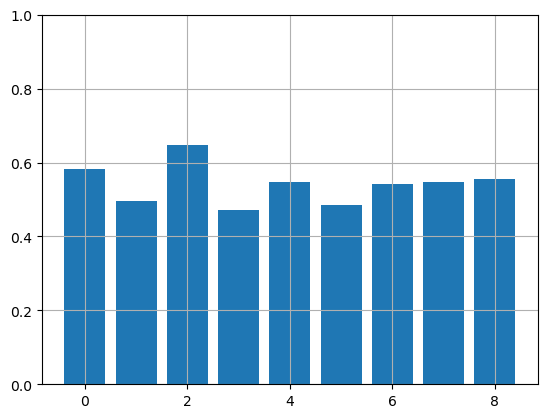

In [35]:
plt.bar(range(9), f1_scores['test_f1_macro'])
plt.ylim(0, 1)
plt.grid(True)
f1_scores

## Walidacja prosta
Jak widać, wyniki nie są szczególnie dobre - dla 8 z 9 podzbiorów uzyskaliśmy F1 < 0.6. Jeżeli teraz przeprowadzimy walidację prostą (czyli uczenie na całym zbiorze uczącym i predykcje na testowym), to raczej też nie uzyskamy zadowalających wyników.

Przeprowadź trening klasyfikatora RandomForest z `random_state=42` i domyślnymi wartościami pozostałych hiperparametrów oraz predykcję na zbiorze testowym.

Wyświetl macierz pomyłek, F1 i dokładność.

Accuracy: 0.6837, F1-macro: 0.6221


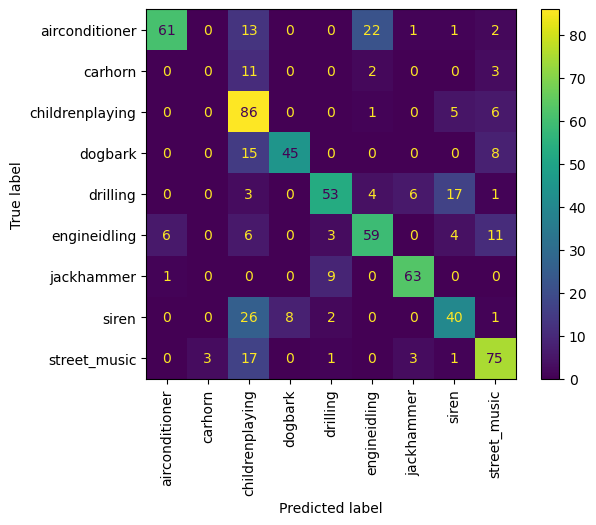

In [36]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.4f}, F1-macro: {f1:.4f}')

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[classes[i] for i in sorted(classes.keys()) if i!=6], xticks_rotation="vertical")

Podobnie jak w analizie PCA, możemy wyświetlić, które cechy miały największy wpływ na wynik klasyfikacji oraz znaleźć indeksy cech, które są najbardziej i najmniej istotne:

In [37]:
print(model.feature_importances_)

# argmax i argmin zwracają indeksy
print(np.argmax(model.feature_importances_),
      np.argmin(model.feature_importances_))

[0.01230971 0.01312104 0.00943114 0.01352949 0.0097568  0.00687716
 0.00899118 0.00933734 0.01133675 0.00710066 0.00766903 0.00541316
 0.0045355  0.01634027 0.00688092 0.00839128 0.00879988 0.01735057
 0.00876428 0.00929733 0.00691043 0.00761609 0.00873022 0.00858683
 0.00671872 0.00603858 0.01669415 0.01323146 0.00828356 0.01368795
 0.00833542 0.00649335 0.00888854 0.00824753 0.01165175 0.0075355
 0.00728005 0.00542884 0.00405907 0.01135665 0.0119265  0.00874933
 0.01231839 0.01070792 0.00785545 0.00828153 0.00720783 0.00815828
 0.00659419 0.00810037 0.00475422 0.00444999 0.01507363 0.01489268
 0.00824644 0.01389274 0.00977538 0.00716054 0.00938774 0.01087845
 0.0114155  0.00855171 0.00848825 0.00572634 0.00501578 0.01577719
 0.00790727 0.00999026 0.00866653 0.01436465 0.00682119 0.0113497
 0.00855814 0.00821265 0.00979749 0.00681294 0.00866012 0.00604594
 0.00318322 0.00261608 0.00203154 0.00256796 0.00249005 0.00251701
 0.00260084 0.00204533 0.00246996 0.00407487 0.00401515 0.003778

*Spoiler*: Największy wpływ na wynik klasyfikacji miała cecha nr 17, a najmniejszy - 85. Cofając się do sposobu tworzenia macierzy `X`, możemy sprawdzić, że najistotniejsza cecha to odchylenie standardowe 5 kanału MFCC, a najmniej istotna - kurtoza 8 kanału.

Moglibyśmy usunąć najmniej istotne cechy i w ten sposób przeprowadzić redukcję wymiarowości, a następnie sprawdzić, jak to wpłynie na wynik klasyfikacji. Nie będziemy tego teraz robić; na razie porównamy wyniki uzyskiwane na różnych zbiorach cech oraz przy użyciu różnych klasyfikatorów.

Przypuszczenia oparte o wyniki dla podzbiorów walidacyjnych potwiedziły się i wyniki uzyskane na zbiorze testowym nie są zbyt dobre, chociaż też nie można powiedzieć, że są tragiczne - dokładność 0.69 dla modelu z domyślnymi wartościami hiperparametrów i przy 9 klasach to całkiem dobry wyniki. Widać natomiast, że np. żaden obiekt z klasy 2 nie zostal zaklasyfikowany prawidłowo, więc warto spróbować uzyskać lepszy model.

# GFCC

Oprócz redukcji wymiarów, możemy też wypróbować inny zestaw cech: w tym przypadku GFCC. Podział na zbiory i etykiety pozostają bez zmian, więc nie musimy ich wczytywać na nowo.

In [38]:
X_gfcc = np.load('gfcc_3D.npy')
X_gfcc.shape

(7334, 341, 13)

Kolejne etapy są takie same - wyznaczamy statystyki, usuwamy klasę 6 z macierzy `X` i dzielimy dane na zbiór uczący i testowy tak, by w testowym był tylko 10 podzbiór, a w uczącym pozostałe 9 podzbiorów.

# Zadanie A
Zrób to poniżej, nie nadpisując starego kodu - będziemy porównywać uzyskane wyniki, więc dobrze będzie mieć dostęp do tego, co wyszło przed chwilą.

In [39]:
#statystyki współczynników GFCC
X_gfcc = np.hstack((np.mean(X_gfcc, axis=1), 
               np.std(X_gfcc, axis=1), 
               np.median(X_gfcc, axis=1), 
               np.percentile(X_gfcc, 25, axis=1), 
               np.percentile(X_gfcc, 75, axis=1), 
               scipy.stats.iqr(X_gfcc, rng=(10, 90), axis=1),
               scipy.stats.kurtosis(X_gfcc, axis=1),
               scipy.stats.skew(X_gfcc, axis=1),
               np.min(X_gfcc, axis=1),
               np.max(X_gfcc, axis=1)
              ))

In [40]:
#usunięcie klasy 6 i podział na zbiory
X_gfcc = X_gfcc[y_not_6]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_gfcc[train_folds_mask])
X_test = scaler.transform(X_gfcc[test_fold_mask])

In [41]:
#walidacja krzyżowa klasyfikatora RandomForest (zastosuj taki sam random_state jak wcześniej)
model_cv = RandomForestClassifier(random_state=42)
f1_scores = cross_validate(model_cv,
                           X_train,
                           y_train,
                           scoring=scoring,
                           groups=train_folds,
                           n_jobs=-1,
                           cv=GroupKFold(n_splits=len(np.unique(train_folds))))

{'fit_time': array([4.93239808, 4.7820971 , 4.97033191, 4.90879607, 4.9104979 ,
        4.88084912, 4.82444477, 4.91888309, 3.96550012]),
 'score_time': array([0.01180005, 0.01532102, 0.00953388, 0.00991797, 0.00952411,
        0.01097488, 0.01497006, 0.00897193, 0.00851679]),
 'test_f1_macro': array([0.50262701, 0.46927166, 0.58506074, 0.44876397, 0.58371177,
        0.54066682, 0.56635847, 0.56722411, 0.60711703])}

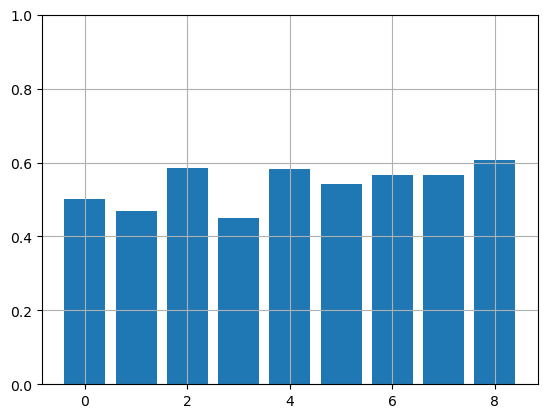

In [42]:
plt.bar(range(9), f1_scores['test_f1_macro'])
plt.ylim(0, 1)
plt.grid(True)
f1_scores

Accuracy: 0.5319, F1-macro: 0.4897


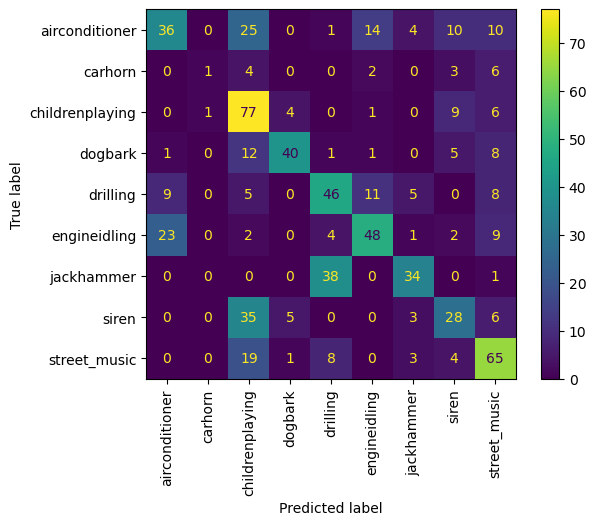

In [43]:
#Przeprowadź trening klasyfikatora RandomForest z random_state=42 i domyślnymi wartościami pozostałych hiperparametrów oraz predykcję na zbiorze testowym. 
#Wyświetl macierz pomyłek, F1 i dokładność

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.4f}, F1-macro: {f1:.4f}')

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[classes[i] for i in sorted(classes.keys()) if i!=6], xticks_rotation="vertical")

# Łączenie cech

Spróbujemy zwiększyć dokładność predykcji ucząc model na obu typach cech naraz. Takie postępowanie, czyli wykorzystywanie zbioru różnych cech, które pojedynczo nie dają dobrych rezultatów, często pozwala znacząco poprawić jakość modelu.

In [44]:
X_gfcc = np.load('gfcc_3D.npy')
X_conc = np.concatenate((X_mfcc, X_gfcc), axis=2)

X_conc.shape

(7334, 341, 26)

In [45]:
# Wylicz statystyki, tym razem dla połączonych macierzy cech
X_conc = np.hstack((np.mean(X_conc, axis=1), 
               np.std(X_conc, axis=1), 
               np.median(X_conc, axis=1), 
               np.percentile(X_conc, 25, axis=1), 
               np.percentile(X_conc, 75, axis=1), 
               scipy.stats.iqr(X_conc, rng=(10, 90), axis=1),
               scipy.stats.kurtosis(X_conc, axis=1),
               scipy.stats.skew(X_conc, axis=1),
               np.min(X_conc, axis=1),
               np.max(X_conc, axis=1)
              ))

In [46]:
X_conc.shape

(7334, 260)

Cech opisujących pojedynczy obiekt mamy teraz co prawda aż 260, ale nadal nie jest to na tyle duża liczba, żeby proces uczenia trwał bardzo długo lub było duże ryzyko przeuczenia modelu, więc możemy nie robić redukcji wymiarowości.

In [47]:
#usuń klasę 6, podziel dane na zbiory i przeprowadź walidację krzyżową, trening i predykcję
X_conc = X_conc[y_not_6]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_conc[train_folds_mask])
X_test = scaler.transform(X_conc[test_fold_mask])

{'fit_time': array([7.13269997, 6.8234601 , 7.11307287, 7.04679799, 7.0551579 ,
        6.8700211 , 7.01399088, 7.08569026, 5.63155508]),
 'score_time': array([0.00971484, 0.01120901, 0.00966096, 0.00935507, 0.00973201,
        0.00969505, 0.00967288, 0.00887489, 0.00858068]),
 'test_f1_macro': array([0.60049863, 0.50225768, 0.63706869, 0.50400985, 0.57199647,
        0.54514889, 0.5874824 , 0.55905022, 0.55547359])}

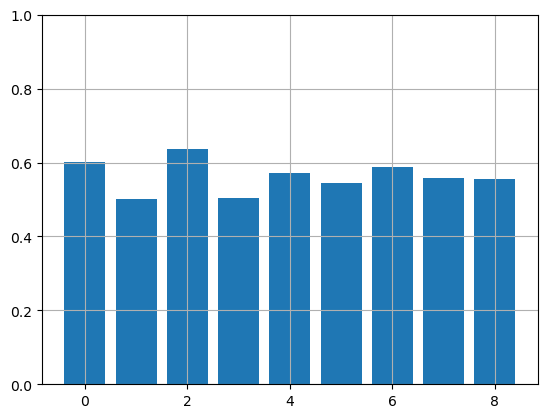

In [48]:
model_cv = RandomForestClassifier(random_state=42)
f1_scores = cross_validate(model_cv,
                           X_train,
                           y_train,
                           scoring=scoring,
                           groups=train_folds,
                           n_jobs=-1,
                           cv=GroupKFold(n_splits=len(np.unique(train_folds))))

plt.bar(range(9), f1_scores['test_f1_macro'])
plt.ylim(0, 1)
plt.grid(True)
f1_scores

Accuracy: 0.6468, F1-macro: 0.5892


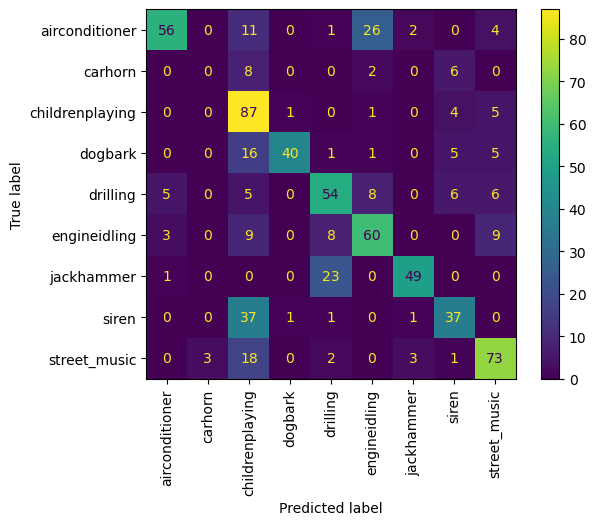

In [49]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.4f}, F1-macro: {f1:.4f}')

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[classes[i] for i in sorted(classes.keys()) if i!=6], xticks_rotation="vertical")

# Optymalizacja

Skoro już wiemy, że na takich danych uzyskujemy najlepsze wyniki, możemy przejść do optymalizacji modelu, korzystając z poznanego na poprzednich zajęciach pakietu optuna.

In [50]:
# !pip install optuna
from optuna import create_study
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold

Na początek wybierzmy takie 3 parametry do optymalizacji:

- `n_estimators` - liczba drzew klasyfikacyjnych, które będą tworzyły las,
- `max_depth` - maksymalna głębokość (liczba poziomów) drzewa,
- `min_samples_split` - minimalna liczba obiektów, które muszą znajdować się w węźle, by można go było poddać kolejnemu podziałowi.

Dodamy też parametr `n_jobs`, który określa liczbę rdzeni, które zostaną wykorzystane do treningu. `-1` oznacza wszystkie dostępne - taki wybór przyspieszy optymalizację, ale spowolni działanie innych procesów.

In [57]:
# definiujemy przestrzeń poszukiwań hiperparametrów
def get_space(trial): 
    space = {"n_estimators": trial.suggest_int("n_estimators", 50, 300),
             "max_depth": trial.suggest_int("max_depth", 5, 30),
             "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
             "n_jobs": -1}
    return space

Definiujemy funkcję celu, dla której będziemy chcieli osiągnąć jak najlepsze wyniki:

In [58]:
# dla przypomnienia - metryka, którą zdefiniowaliśmy przy okazji kros-walidacji:
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# definiujemy funkcję celu
def objective(trial, model, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl,
                            X,
                            y,
                            groups=train_folds,
                            scoring=scoring,
                            cv=GroupKFold(n_splits=len(np.unique(train_folds))), return_train_score=True)

    # zwracamy średni wynik F1 z walidacji krzyżowej
    return np.mean(scores['test_f1_macro'])

Następnie definiujemy model używany do optymalizacji oraz liczbę iteracji (triali).

10 to liczba iteracji, która policzy się w rozsądnym czasie; przy 60 powinniśmy już uzyskać w miarę dobre wyników. W domu możesz spróbować zwiększyć ją np. do 100 lub 150 i zobaczyć, czy wyniki uda się poprawić, czy optimum będzie jednak osiągnięte wcześniej i nie ma sensu optymalizować modelu dłużej.

In [59]:
trials = 10 #liczba prób

model = RandomForestClassifier # bez nawiasów! - przekazujemy klasę, nie tworzymy jej instancji

Na koniec tworzymy analizę (*study*); określamy, czy dążymy do jak największej (`direction='maximize'`), czy jak najmniejszej (`direction='minimize'`) wartości metryki:

In [60]:
study_RF = optuna.create_study(direction='maximize',
                               study_name='RandomForest_optimization')

[I 2026-01-26 13:04:48,124] A new study created in memory with name: RandomForest_optimization


In [61]:
%%time
#%%time to komenda służąca do pomiaru czasu wykonywania komórki, musi znajdować się na samej górze komórki
study_RF.optimize(lambda x: objective(x, model, X_train, y_train), n_trials=trials)

[I 2026-01-26 13:04:58,179] Trial 0 finished with value: 0.5360824818331995 and parameters: {'n_estimators': 123, 'max_depth': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.5360824818331995.
[I 2026-01-26 13:05:05,359] Trial 1 finished with value: 0.5117562064168543 and parameters: {'n_estimators': 129, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 0 with value: 0.5360824818331995.
[I 2026-01-26 13:05:30,131] Trial 2 finished with value: 0.5610720212367579 and parameters: {'n_estimators': 269, 'max_depth': 23, 'min_samples_split': 8}. Best is trial 2 with value: 0.5610720212367579.
[I 2026-01-26 13:05:44,248] Trial 3 finished with value: 0.5610495509623051 and parameters: {'n_estimators': 163, 'max_depth': 21, 'min_samples_split': 9}. Best is trial 2 with value: 0.5610720212367579.
[I 2026-01-26 13:05:59,448] Trial 4 finished with value: 0.5625013848795594 and parameters: {'n_estimators': 177, 'max_depth': 20, 'min_samples_split': 7}. Best is trial 4 with value: 0.

CPU times: user 12min 28s, sys: 6.83 s, total: 12min 35s
Wall time: 1min 52s


In [62]:
print('Best params: ', study_RF.best_params)

Best params:  {'n_estimators': 177, 'max_depth': 20, 'min_samples_split': 7}


# Zadanie B

Accuracy: 0.6667, F1-macro: 0.6069


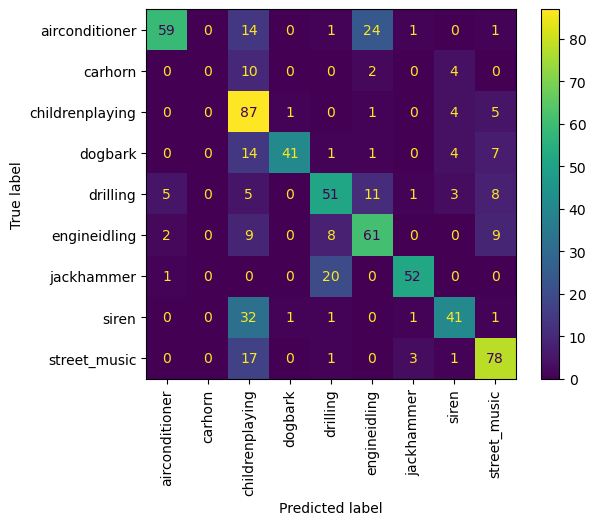

In [63]:
#Wytrenuj model o najlepszych hiperparametrach, przeprowadź predykcję i wylicz metryki
model = RandomForestClassifier(n_estimators=177, max_depth=20, min_samples_split=7, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.4f}, F1-macro: {f1:.4f}')

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[classes[i] for i in sorted(classes.keys()) if i!=6], xticks_rotation="vertical")

Czy wyniki uzyskane przy użyciu optymalizowanego modelu są lepsze, niż te, które uzyskaliśmy stosując domyślne wartości hiperparametrów?

In [ ]:
# Są odrobinę lepsze

# ExtraTrees

Algorytmem bardzo podobnym do lasu losowego jest algorytm [ExtraTrees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier). Od lasu losowego różni go przede wszystkich kryterium podziału drzewa w danym węźle: w ExtraTrees kryterium jest losowe, a w lasach losowych stosowane jest kryterium optymalne (dające najlepszy podział). Dzięki temu algorytm ExtraTrees zazwyczaj jest szybszy. Kolejną istotną różnicą jest to, że podczas podziału danych w lesie losowym stosowane jest tzw. losowanie ze zwracaniem, natomiast w ExtraTrees nie - oznacza to, że w ExtraTrees obserwacje podane do kolejnych drzew nie będą się powtarzać, natomiast w lesie losowym mogą.

ExtraTrees najczęściej daje (trochę) gorsze wyniki niż las losowy, jednak nie zawsze tak jest - jeżeli mamy czas, warto wypróbować oba algorytmy.

# Zadanie C

Przeprowadź optymalizację dla algorytmu ExtraTrees. Następnie wytrenuj model o najlepszych parametrach, przeprowadź predykcję i wylicz metryki. Który model daje lepsze wyniki klasyfikacji?

In [66]:
model = ExtraTreesClassifier

#uzupełnij funkcję get_space
def get_space(trial): 
    space = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "n_jobs": -1
        }
    return space
trials = 60 #liczba prób

def objective(trial, model, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl,
                            X,
                            y,
                            groups=train_folds,
                            scoring=scoring,
                            cv=GroupKFold(n_splits=len(np.unique(train_folds))), return_train_score=True)

    return np.mean(scores['test_f1_macro'])

In [67]:
study_ET = optuna.create_study(direction='maximize',
                               study_name='ExtraTrees_optimization')

[I 2026-01-26 13:17:30,342] A new study created in memory with name: ExtraTrees_optimization


In [68]:
%%time
study_ET.optimize(lambda x: objective(x, model, X_train, y_train), n_trials=trials)

[I 2026-01-26 13:17:33,335] Trial 0 finished with value: 0.5065970431359769 and parameters: {'n_estimators': 185, 'max_depth': 7}. Best is trial 0 with value: 0.5065970431359769.
[I 2026-01-26 13:17:35,453] Trial 1 finished with value: 0.537302299476105 and parameters: {'n_estimators': 169, 'max_depth': 9}. Best is trial 1 with value: 0.537302299476105.
[I 2026-01-26 13:17:37,626] Trial 2 finished with value: 0.5547143787526685 and parameters: {'n_estimators': 130, 'max_depth': 14}. Best is trial 2 with value: 0.5547143787526685.
[I 2026-01-26 13:17:42,104] Trial 3 finished with value: 0.5597906661613334 and parameters: {'n_estimators': 204, 'max_depth': 26}. Best is trial 3 with value: 0.5597906661613334.
[I 2026-01-26 13:17:47,021] Trial 4 finished with value: 0.5590194589926303 and parameters: {'n_estimators': 237, 'max_depth': 27}. Best is trial 3 with value: 0.5597906661613334.
[I 2026-01-26 13:17:49,233] Trial 5 finished with value: 0.5574404096491355 and parameters: {'n_estimato

CPU times: user 20min 44s, sys: 57.5 s, total: 21min 42s
Wall time: 4min 22s


Accuracy: 0.6766, F1-macro: 0.6142


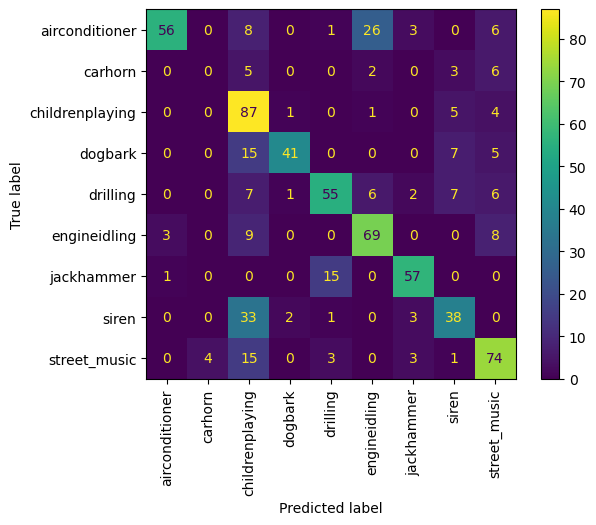

In [69]:
#Wytrenuj model o najlepszych hiperparametrach, przeprowadź predykcję i wylicz metryki
model = ExtraTreesClassifier(n_estimators=207, max_depth=22, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.4f}, F1-macro: {f1:.4f}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[classes[i] for i in sorted(classes.keys()) if i!=6], xticks_rotation="vertical")

# Zadanie D

Porównaj uzyskane wszystkimi metodami macierze pomyłek. Która klasa jest najczęściej źle klasyfikowana, bez względu na użyty model? Jak myślisz, dlaczego?

Niezalenie od algorytmu, klasie "childrenplaying" przypisywane są obiekty innych klas, np. "siren" lub "carhorn". Jest to związane z faktem, ze dzieci wydają uciązliwe dźwięki, praktycznie nieodróznialne od uciązliwego hałasu syren i klaksonów.

Airconditioner oraz engineidling bywają mylone, ale te dwa dźwięki są do siebie w prawdziwym zyciu dosyć podobne. To samo dla jackhammer i drilling.